In [1]:
import os
import torch
from torch import nn
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from clipseg_model import CLIPSeg
from data.cub_parts_dataset import CUBPartsDataset, collate_fn

%load_ext autoreload
%autoreload 2

# `CUB/PASCUB` Dataset

In [31]:
from clipseg_train import load_concepts_cub
state_dict = torch.load('checkpoints/clipseg_pascub_ft.pt')

with open('concepts/CUB/parts.txt') as fp:
    part_texts = fp.read().splitlines()

concept_sets = load_concepts_cub()

model = CLIPSeg(
    part_texts=part_texts,
    concepts_dict=concept_sets,
    meta_category_text='bird',
    k=50,
    state_dict=state_dict
)

Some weights of CLIPSegForImageSegmentation were not initialized from the model checkpoint at CIDAS/clipseg-rd64-refined and are newly initialized: ['non_object_embedding', 'text_adapter.fc.0.weight', 'text_adapter.fc.2.weight', 'tunable_linear.weight', 'visual_adapter.fc.0.weight', 'visual_adapter.fc.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
dataset_test = CUBPartsDataset('datasets/PASCUB', split='test')
dataloader_test = DataLoader(dataset=dataset_test, batch_size=4, shuffle=False, collate_fn=collate_fn)
dataloader_test_iter = iter(dataloader_test)

In [77]:
# inference
batch = next(dataloader_test_iter)
model.eval()
with torch.no_grad():
    img_paths, label_paths, imgs, labels = batch
    imgs = list(imgs)
    logits = model.inference(imgs)

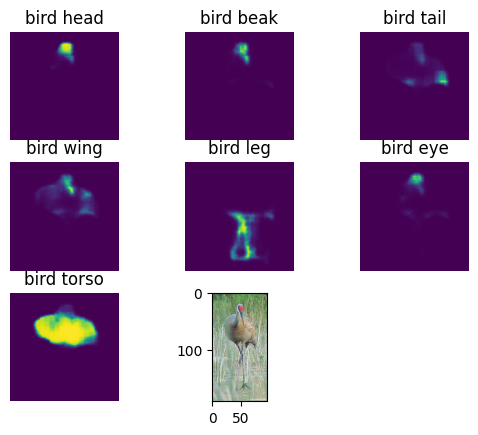

In [78]:
fig, axes = plt.subplots(3, 3)
for score_map, ax, text in zip(logits[0].cpu().numpy(), axes.flatten(), model.part_texts):
    ax.imshow(score_map)
    ax.axis('off')
    ax.title.set_text(text)

axes[-1,-2].imshow(batch[2][0].permute(1,2,0))
fig.delaxes(axes[-1,-1])

In [74]:
c, orig_h, orig_w = batch[2][0].shape

In [82]:
import numpy as np

logits_reshaped = F.interpolate(logits, size=(orig_h, orig_w))
logits_np = logits_reshaped.cpu().numpy()
b, c, h, w = logits.shape
background = np.full((b, 1, orig_h, orig_w), 0.1)
logits_wb = np.concatenate([logits_np, background], axis=1)

In [83]:
seg_idxs = np.argmax(logits_wb, axis=1)
seg_idxs.shape

(4, 191, 96)

In [84]:
import numpy as np
from matplotlib import colors
from matplotlib import colormaps

def make_cmap(n):
    norm = colors.Normalize(vmin=0, vmax=n)
    cmap = colormaps['tab20']
    cmap_arr = np.array([cmap(norm(i))[:-1] for i in range(n)])
    return (cmap_arr * 255).astype(np.uint8)

cmap_arr = make_cmap(8)

In [85]:
seg_idx = seg_idxs[0]
seg_map = np.zeros((h, w, 3), dtype=np.uint8)
for idx, color in enumerate(cmap_arr):
    seg_map[seg_idx == idx, :] = color
seg_map = seg_map[..., ::-1]

In [90]:
seg_map * 0.5 + batch[2][0].permute(1,2,0).numpy() * 0.5

array([[[114. , 164. , 153.5],
        [103.5, 153.5, 142. ],
        [112.5, 162.5, 156. ],
        ...,
        [135. , 167.5, 164.5],
        [132.5, 174. , 164. ],
        [126. , 169.5, 161. ]],

       [[126.5, 171. , 164. ],
        [112.5, 158. , 145. ],
        [108. , 157. , 138.5],
        ...,
        [130.5, 167.5, 166. ],
        [128.5, 168.5, 163. ],
        [127.5, 167.5, 162. ]],

       [[129. , 172. , 164.5],
        [117. , 162.5, 148.5],
        [104.5, 152. , 134. ],
        ...,
        [130. , 168. , 161.5],
        [126.5, 161. , 156.5],
        [129.5, 166.5, 162. ]],

       ...,

       [[156. , 204. , 192. ],
        [148. , 195.5, 186. ],
        [148.5, 192. , 182.5],
        ...,
        [166.5, 211.5, 193.5],
        [158. , 202. , 188.5],
        [151.5, 196. , 187.5]],

       [[157.5, 204. , 194.5],
        [149.5, 197.5, 185.5],
        [145.5, 191.5, 179. ],
        ...,
        [152. , 197. , 186. ],
        [146.5, 191.5, 180.5],
        [146. ,

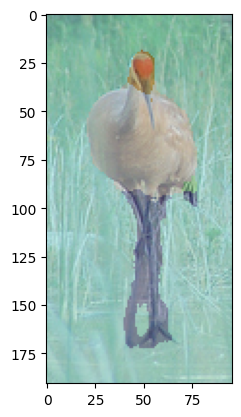

In [91]:
plt.imshow((seg_map * 0.5 + batch[2][0].permute(1,2,0).numpy() * 0.5).astype(np.uint8))

# `Cars` Dataset

In [3]:
from clipseg_train import load_concepts_cars
state_dict = torch.load('checkpoints/clipseg_ft_VA_L_F_D_voc.pth')
state_dict = state_dict['model']

with open('concepts/CARS/parts.txt') as fp:
    part_texts = fp.read().splitlines()

concept_sets = load_concepts_cars()

model = CLIPSeg(
    part_texts=part_texts,
    concepts_dict=concept_sets,
    meta_category_text='car',
    k=50,
    state_dict=state_dict
)

Some weights of CLIPSegForImageSegmentation were not initialized from the model checkpoint at CIDAS/clipseg-rd64-refined and are newly initialized: ['non_object_embedding', 'text_adapter.fc.0.weight', 'text_adapter.fc.2.weight', 'tunable_linear.weight', 'visual_adapter.fc.0.weight', 'visual_adapter.fc.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'clipseg.configuration_clipseg.CLIPSegConfig'> 512


In [17]:
from torchvision.datasets import StanfordCars
cars_dataset_train = StanfordCars('datasets/CARS', split='train', download=True)
cars_dataset_val = StanfordCars('datasets/CARS', split='test', download=True)
cars_dataloader_train = DataLoader(dataset=cars_dataset_train, batch_size=4, shuffle=False, collate_fn=collate_fn)
cars_dataloader_val = DataLoader(dataset=cars_dataset_val, batch_size=4, shuffle=False, collate_fn=collate_fn)
cars_dataloader_val_iter = iter(cars_dataloader_val)

In [18]:
batch = next(cars_dataloader_val_iter)
model.eval()
with torch.no_grad():
    imgs, labels = batch
    imgs = list(imgs)
    logits = model.inference(imgs)

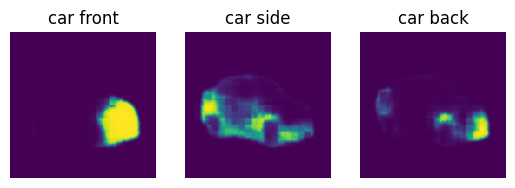

In [22]:
fig, axes = plt.subplots(1, 3)
for score_map, ax, text in zip(logits[0].cpu().numpy(), axes.flatten(), model.part_texts):
    ax.imshow(score_map)
    ax.axis('off')
    ax.title.set_text(text)

# Visualizations

In [27]:
import numpy as np
from matplotlib import colors
from matplotlib import colormaps

idx = 2
norm = colors.Normalize(vmin=0, vmax=5)
# This is one of the qualitative color maps
cmap = colormaps['tab20']
rgba = cmap(norm(idx))

# Make a 10*10*3 array filled with the chosen color
rgba_arr = np.expand_dims(np.array(rgba[:-1]), axis=(0,1))
rgb_arr_expanded = np.tile(rgba_arr, (10, 10, 1))

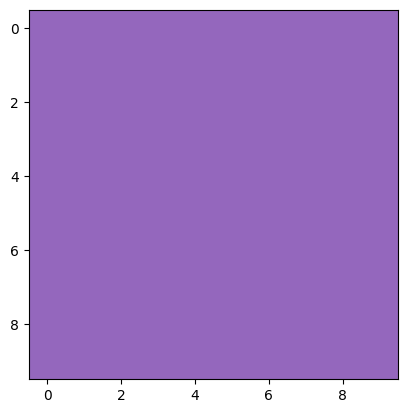

In [28]:
plt.imshow(rgb_arr_expanded)